# Demo - Black Box Attack with CIFAR10

In [1]:
import os
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import attacks

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load CIFAR10 Data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

batch_size = 24

cifar10_train = dsets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
cifar10_test  = dsets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=batch_size,
                                        shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

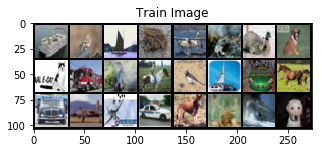

In [5]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 2. Load Holdout Model & Save Adversarial Images

In [6]:
from models import Holdout
model = Holdout().cuda()
model.load_state_dict(torch.load("model/holdout.pth"))

In [7]:
pgd_attack = attacks.PGD(model=model)

# If you want to reduce the space of dataset, set 'to_unit8' as True
# If you don't want to know about accuaracy of the model, set accuracy as False
pgd_attack.save(data_loader=test_loader, file_name="data/cifar10_pgd.pt", to_uint8=True, accuracy=True)

- Save Progress : 100.00 %        
- Accuracy of the model : 0.000000 %
- Save Complete!


## 3. Load Adversarial Images & Attack Target Model

In [8]:
# When scale=True it automatically tansforms images to [0, 1]
adv_data = pgd_attack.load(file_name="data/cifar10_pgd.pt", scale=True)
adv_loader = torch.utils.data.DataLoader(adv_data, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

In [9]:
from models import Target
model = Target().cuda()
model.load_state_dict(torch.load("model/target.pth"))

In [10]:
# Accuracy with Original CIFAR10
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 77.770000 %


In [11]:
# Accuracy with Adversarial CIFAR10
model.eval()

correct = 0
total = 0

for images, labels in adv_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 5.100000 %
